This series of exercise make use of a handwritten digits dataset that consists of 5000 training examples,
where each example is a 20 pixel by 20 pixel grayscale image of the digits

In [292]:
#Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

Since the dataset was given in .mat format instead of the usual .txt format, I had to make use of scipy loadmat function for the job. Since loadmat load .mat files as a dictionary with variable names as keys,
assigning X and y is as simple as accessing the dict with the variables’ keys.

In [293]:
# Use loadmat to load matlab files
mat=loadmat("ex3data1.mat")
X=mat["X"]
y=mat["y"]

In [294]:
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


The code block below construct 100(10*10) subplots and randomly visualize 100 out of the 5000 training with (np.random.randint(0,5001))
examples using plt.imshow. Take note we have to reshape the training example back to 20 X 20 pixel 
before we can visualize it and adding order="F" as a parameter into the reshape function ensure 
that the orientation of the image is upright.

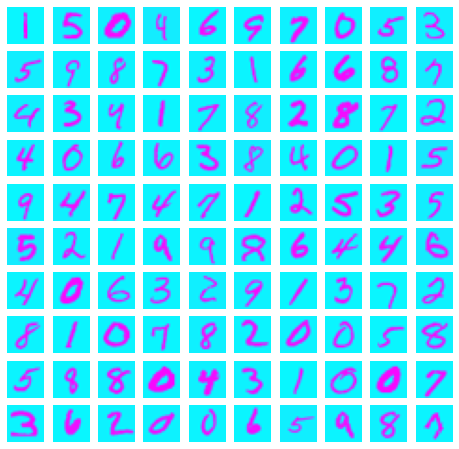

In [295]:

import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"),cmap='cool')
        axis[i,j].axis("off")

#Alternate Ways to do the same with "matshow" function

import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].matshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"),cmap="hot")
        axis[i,j].axis("off")

## Computing the cost function and gradient


$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\Theta_j$ for $j\geq 1$

In [296]:
def sigmoid(z):
    
    return 1/ (1 + np.exp(-z))

In [297]:
sigmoid(0)

0.5

def learning_costfunction(X,y,theta,Lambda):
    """
    Takes in numpy array of theta, X, y, and float lambda to compute the regularized logistic cost function 
    """
    m=len(y)
    prediction= sigmoid(X @ theta)
    error= (-y * np.log(prediction)) - ((1-y)*np.log(1-prediction))
    cost=1/m * np.sum(error)
    regz_cost=cost + (Lambda/2*m) * sum(theta[1:]** 2)
    #calculating gradient
    j_0= 1/m * (X.transpose() @ (prediction-y))[0]
    j_1=  1/m * (X.transpose() @ (prediction-y))[1:] + (Lambda/m )* theta[1:]
    gradient= np.vstack((j_0[:,np.newaxis],j_1))
    return regz_cost[0],gradient

In [299]:
def lrCostFunction( X, y,theta,Lambda):
    """
    Takes in numpy array of theta, X, y, and float lambda to compute the regularized logistic cost function 
    """
    
    m=len(y)
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0= 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad= np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad

In [257]:
def lrCostFunction( X, y,theta, Lambda):
    """
    Takes in numpy array of theta, X, y, and float lambda to compute the regularized logistic cost function 
    """
    
    m=len(y)
    predictions = sigmoid(X @ theta)
    error = (-y * np.log(predictions)) - ((1-y)*np.log(1-predictions))
    cost = 1/m * sum(error)
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # compute gradient
    j_0= 1/m * (X.transpose() @ (predictions - y))[0]
    j_1 = 1/m * (X.transpose() @ (predictions - y))[1:] + (Lambda/m)* theta[1:]
    grad= np.vstack((j_0[:,np.newaxis],j_1))
    return regCost[0], grad

In [300]:
theta_t= np.array([-2,-1,1,2]).reshape(4,1)
x_t=np.linspace(0.1,1.5,15).reshape(3,5).T
x_t=np.hstack((np.ones((5,1)),x_t))
y_t=np.array([1,0,1,0,1]).reshape(5,1)
cost,gradient=lrCostFunction(x_t,y_t,theta_t,3)
print("Cost:",cost,"Expected cost: 2.534819")
print("Gradients:\n",gradient,"\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


## One-vs-all Classification

Now for the classification task.
Since we have more than one class, we will have to train multiple logistic regression classifiers 
using one-vs-all classification method (one classifier for each class).

In [301]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = lrCostFunction(X, y,theta, Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta , J_history

The gradientDescent function is the usual optimizing function that we had implemented previously. As for oneVsAll , it iterates through all the classes and trained a set of theta for each class using gradient descent ( fmincg function was used in the assignment). all_theta then captures all the optimized theta in a list and return as a numpy array, reshaped into a matrix of theta where the i-th row corresponds to the classifier for label i. np.where comes in handy here to get a vector of y with 1/0 for each class to conduct our binary classification task within each iteration.

In [302]:
def oneVsAll(X, y, num_labels, Lambda):
    """
    Takes in numpy array of X,y, int num_labels and float lambda to train multiple logistic regression classifiers
    depending on the number of num_labels using gradient descent. 
    
    Returns a matrix of theta, where the i-th row corresponds to the classifier for label i
    """
    m, n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n+1,1))
    all_theta = []
    all_J=[]
    # add intercept terms
    
    X = np.hstack((np.ones((m,1)),X))
    
    for i in range(1,num_labels+1):
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),initial_theta,1,300,Lambda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels,n+1), all_J

In [303]:
all_theta, all_J = oneVsAll(X, y, 10, 0.1)

In [304]:
all_J

[0.6931471805599918,
 0.5023622031634086,
 0.3499754654993192,
 0.21624498564517172,
 0.1303670542629614,
 0.10121558949588493,
 0.09411030842241656,
 0.09019167868133922,
 0.08691137308875076,
 0.08402958068650426,
 0.08146909179935492,
 0.07917611464053921,
 0.0771087436446125,
 0.07523356483031668,
 0.0735235678547035,
 0.07195666795550264,
 0.07051462343636065,
 0.06918222810350491,
 0.06794669995530515,
 0.06679721246168749,
 0.06572453098603129,
 0.06472072776182097,
 0.0637789562651601,
 0.06289327099271835,
 0.062058482303860206,
 0.06127003859677271,
 0.06052392997972998,
 0.05981660898423098,
 0.05914492489269977,
 0.05850606902059308,
 0.05789752887175933,
 0.05731704952669848,
 0.056762600961707724,
 0.05623235025859614,
 0.05572463786855001,
 0.055237957253670894,
 0.05477093735601247,
 0.054322327444272386,
 0.053890983968472264,
 0.053475859117385206,
 0.053075990825521425,
 0.05269049401872673,
 0.05231855292192505,
 0.05195941428078582,
 0.05161238137233879,
 0.0512768

Text(0.5, 1.0, 'Cost function using Gradient Descent')

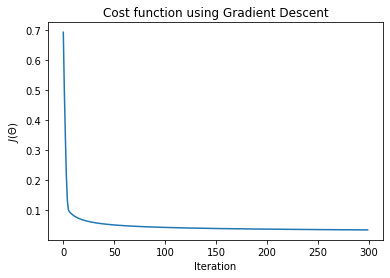

In [305]:
plt.plot(all_J[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [306]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of X(i) for each class and predict the label
    
    return a vector of prediction
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    predictions = X @ all_theta.T
    return np.argmax(predictions,axis=1)+1

In [307]:
pred = predictOneVsAll(all_theta, X)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 91.46 %


## Nerual Networks

Finally, time for neural networks. With the same dataset, we aimed to achieve higher accuracy using a more complex algorithm such as the neural network. For the first part of the exercise, the optimized theta values were given to us and we are supposed to implement feedforward propagation to obtain the prediction and model accuracy.

### Loading of theta

In [308]:
mat2=loadmat("ex3weights.mat")
Theta1=mat2["Theta1"] # Theta1 has size 25 x 401
Theta2=mat2["Theta2"] # Theta2 has size 10 x 26

In [309]:
Theta1[0][0:5]

array([-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, -6.92223359e-06,
        8.88278871e-05])

In [273]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    return np.argmax(a2,axis=1)+1
pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 97.52 %


The print statement print: Training Set Accuracy: 97.52 % . A much higher accuracy as compared to multi-class logistic regression!

In last assigment, we worked towards implementing a neural network from scratch. We start off by computing the cost function and gradient of theta.

In [277]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid)

#return is g'(z2) = a2 . * (1 - a2)

### Compute the Neural Networks cost function

$J(\Theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\Theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\Theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2]$

In [278]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

In [279]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.append(Theta1.flatten(),Theta2.flatten())
J,reg_J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)[0:4:3]
print("Cost at parameters (non-regularized):",J,"\nCost at parameters (Regularized):",reg_J)

Cost at parameters (non-regularized): 0.2876291651613188 
Cost at parameters (Regularized): 0.38376985909092354


### Random initialization

Select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init} , \epsilon_{init}]$

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network

$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$

In [281]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [282]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [287]:
debug_J  = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 3)
print("Cost at (fixed) debugging parameters (w/ lambda = 3):",debug_J[3])

Cost at (fixed) debugging parameters (w/ lambda = 3): 0.576051246950133


### Learning parameters using Gradient Descent

In [288]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [290]:
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,0.8,800,1,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [291]:
pred3 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 94.36 %
